In [ ]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from keras.layers import Input, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from functools import reduce
import os
from PIL import Image

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [ ]:
BATCH_SIZE = 100
INTERMEDIATE_DIM = 256
LATENT_DIM = 2
INPUT_SIZE = 28 * 28
EPSILON_STD = 1.0
EPOCHS = 50

In [ ]:
def sampling(args):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], LATENT_DIM), mean=0.,
                              stddev=EPSILON_STD)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [ ]:
# input to our encoder
x = Input(shape=(INPUT_SIZE,), name="input")
# intermediate layer
h = Dense(INTERMEDIATE_DIM, activation='relu', name="encoding")(x)
# defining the mean of the latent space
z_mean = Dense(LATENT_DIM, name="mean")(h)
# defining the log variance of the latent space
z_log_var = Dense(LATENT_DIM, name="log-variance")(h)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(LATENT_DIM,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoding (Dense)               (None, 256)          200960      ['input[0][0]']                  
                                                                                                  
 mean (Dense)                   (None, 2)            514         ['encoding[0][0]']               
                                                                                                  
 log-variance (Dense)           (None, 2)            514         ['encoding[0][0]']               
                                                                                            

In [ ]:
# Input to the decoder
input_decoder = Input(shape=(LATENT_DIM,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h = Dense(INTERMEDIATE_DIM, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(INPUT_SIZE, activation='sigmoid', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_h (Dense)           (None, 256)               768       
                                                                 
 flat_decoded (Dense)        (None, 784)               201488    
                                                                 
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor,
            z_log_var=z_log_var, z_mean=z_mean,
            original_dim=INPUT_SIZE):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(
        1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE)

Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 10s 160us/sample - loss: 188.6382
Epoch 2/50
60000/60000 [==============================] - 12s 197us/sample - loss: 169.0495
Epoch 3/50
60000/60000 [==============================] - 9s 149us/sample - loss: 165.7320
Epoch 4/50
60000/60000 [==============================] - 9s 150us/sample - loss: 163.5466
Epoch 5/50
60000/60000 [==============================] - 9s 148us/sample - loss: 161.7108
Epoch 6/50
60000/60000 [==============================] - 9s 150us/sample - loss: 160.1669
Epoch 7/50
60000/60000 [==============================] - 9s 152us/sample - loss: 158.9874
Epoch 8/50
60000/60000 [==============================] - 9s 154us/sample - loss: 158.0876
Epoch 9/50
60000/60000 [==============================] - 9s 148us/sample - loss: 157.3543
Epoch 10/50
60000/60000 [==============================] - 9s 148us/sample - loss: 156.7686
Epoch 11/50
60000/60000 [==============================] - 10s 1

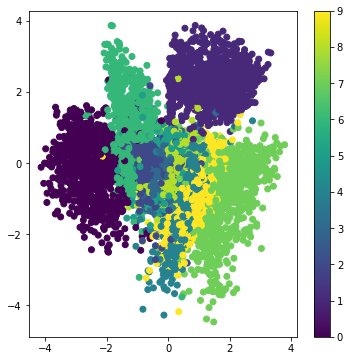

In [ ]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=BATCH_SIZE)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

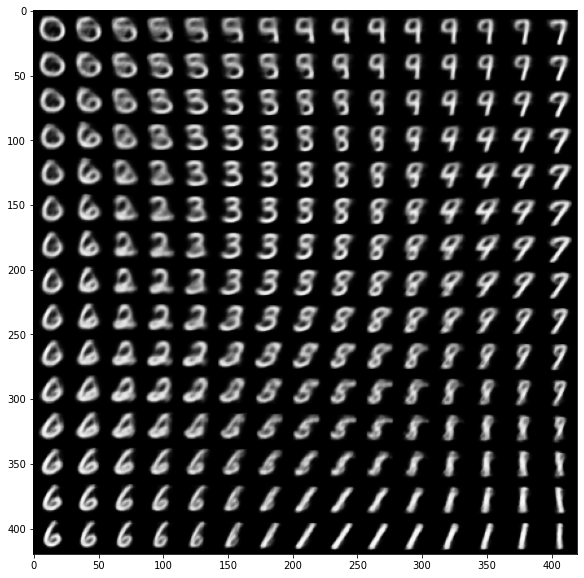

In [ ]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

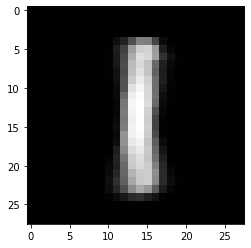

In [ ]:
plt.imshow(decoder.predict(np.array([[1.5, 1.5]]))[0].reshape(28, 28), cmap='gray')